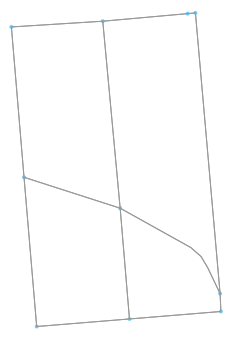

(<Figure size 281.145x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4d3da331d0>)

In [110]:
import numpy as np
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, Polygon, LineString

# get osm graph

# get bbox bounds: 

north = 37.7599 # max lat 
south = 37.7569 # min lat

east = -122.3997 # max lng
west = -122.4023 # min lng 
 
G = ox.graph_from_bbox(north, south, east, west, network_type='walk')

G_projected = ox.project_graph(G)
ox.plot_graph(G_projected)


In [61]:
# explore graph 

basic_stats = ox.basic_stats(G)
    
print("\n n (number of nodes in the graph):", basic_stats['n'])
print("\n m (number of edges in the graph):", basic_stats['m'])

print("\n street_length_total (sum in meters):", basic_stats['street_length_total'])



 n (number of nodes in the graph): 10

 m (number of edges in the graph): 26

 street_length_total (sum in meters): 1420.966


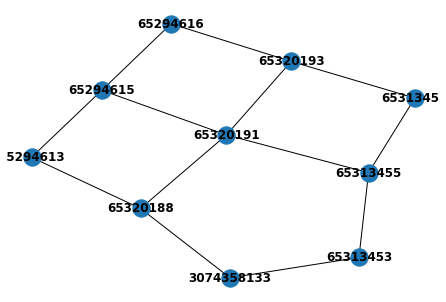

In [79]:
# get nodes and edges 

# new_G = ox.add_edge_lengths(G)

nodes_list = list(G.nodes)
edges_list = list(G.edges)

# print(nodes_list)
# print(edges_list)

cleaned_edges_list = []

# build a new graph from list of edges and nodes 

G_new = nx.MultiGraph()

G_new.add_nodes_from(nodes_list)

G_new.add_edges_from(edges_list)


for e in G_new.edges(data=True):
    e[2]['distance'] = 5

nx.draw(G_new, with_labels=True, font_weight='bold')





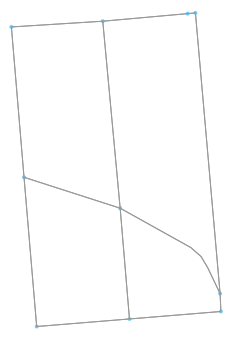

geometry
65294613    POINT (-122.4020923 37.7596792)
Name: geometry, dtype: object

geom type
65294613    Point
dtype: object

x
65294613   -122.402092
Name: x, dtype: float64

y
65294613    37.759679
Name: y, dtype: float64


,osmid,x,y,geometry
65294613,65294613,-122.402092,37.759679,POINT (-122.4020923 37.7596792)
65294615,65294615,-122.401970,37.758389,POINT (-122.4019697 37.758389)
65294616,65294616,-122.401847,37.757108,POINT (-122.4018467 37.757108)
65320191,65320191,-122.400960,37.758119,POINT (-122.40096 37.7581188)
65320193,65320193,-122.400870,37.757168,POINT (-122.4008696 37.757168)
65313453,65313453,-122.400154,37.759790,POINT (-122.4001542 37.7597898)
65313455,65313455,-122.399914,37.757380,POINT (-122.399914 37.7573804)
65313458,65313458,-122.399907,37.757227,POINT (-122.3999067 37.7572271)
3074358133,3074358133,-122.400235,37.759784,POINT (-122.4002355 37.7597842)
65320188,65320188,-122.401130,37.759723,POINT (-122.40113 37.7597235)


In [114]:
G = ox.graph_from_bbox(north, south, east, west, network_type='walk')

G_projected = ox.project_graph(G)
ox.plot_graph(G_projected)

nodes, edges = ox.graph_to_gdfs(G) # make two dataframes - one for nodes and one for edges

# nodes # show nodes df

# edges # show 

df = nodes 

curr_node = nodes.loc[nodes['osmid'] == 65294613] # look up info for the node with id 65294613

print("geometry")
print(curr_node.geometry)

print("\ngeom type")
print(curr_node.geom_type)

print("\nx")
print(curr_node.x)

print("\ny")
print(curr_node.y)

nodes